In [2]:
import os
import sys
DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/MLQD'
path_to_file = str(DIR) + '/' + 'evolution.py'
if os.path.isfile(path_to_file):
    MLQD_DIR = DIR
else:
    MLQD_DIR = os.getcwd() + '/MLQD'
if MLQD_DIR not in sys.path:
    sys.path.append(MLQD_DIR)

In [3]:
import numpy as np
from evolution import quant_dyn
import matplotlib.pyplot as plt

We consider spin-boson model as was consider in our published study https://iopscience.iop.org/article/10.1088/1367-2630/ac3261

\begin{align} \label{eq:sb}
    \boldsymbol{\rm H} = \frac{1}{2}\epsilon \boldsymbol{\sigma}_{z}  + \frac{1}{2}\Delta \boldsymbol{\sigma}_{x} + \sum_{k} \omega_k \boldsymbol{\rm b}_k^\dagger \boldsymbol{\rm b}_k + \frac{1}{2} \boldsymbol{\sigma}_z \boldsymbol{\rm F},
\end{align}
here $\boldsymbol{\sigma}_z$ and $\boldsymbol{\sigma}_x$ are the Pauli matrices, i.e., $\boldsymbol{\sigma}_z = | e\rangle \langle e| - | g \rangle \langle g|$, $\boldsymbol{\sigma}_x =  |e\rangle \langle g| + | g \rangle \langle  e|$. $\epsilon$ and $\Delta$ are the energy bias and tunneling matrix element, respectively. $\omega_k$ is the frequency corresponds to $k$ bath mode and $\boldsymbol{\rm b}_k^\dagger$ is the corresponding bath creation operator. $\boldsymbol{\rm F}$ is the interaction operator and can be expressed as $\boldsymbol{\rm F} = \sum_k \frac{c_k}{\sqrt{2 \omega_k}} (\boldsymbol{\rm b}_k + \boldsymbol{\rm b}_k^\dagger)$, where $c_k$ denotes the coupling strength between system and $k$ bath mode. Initially, we consider that the system is in the excited state $|e\rangle$ (by absorbing a photon of energy equal to the energy gap between the two states) and we let the system to be relaxed by exchanging its energy with the bath.  

We consider the Drude–Lorentz spectral density 
$$
    J_{\text{b}}(\omega)=2 \lambda \frac{\omega \gamma}{\omega^{2}+\gamma^{2}},
$$
with $\gamma$ as characteristic frequency and $\lambda$ as the reorganization energy.

We use the Hierarchical equations of motion (HEOM) approach and generate data for all the possible combinations of the following parameters: $\epsilon = \{0, 1\}$, the reorganization energy $\lambda \in \{0.1$, $0.2$, $0.3$, $0.4$, $0.5$, $0.6$, $0.7$, $0.8$, $0.9$, $1.0 \},$ the characteristic frequency $\gamma \in \{1$, $2$, $3$, $4$, $5$, $6$, $7$, $8$, $9$, $10\},$ inverse temperature $\beta = 1/T \in \{0.1$, $0.25$, $0.5$, $0.75$, $1\}$. It should be noted that all parameters are in atomic units (a.u.). 

We generate 500 trajectories for each case (symmetric and asymmetric $\epsilon = \{0, 1\}$) and then train a CNN model following the OSTL approach. You can grab the trajectories from our **QDDSET-1 dataset** [Coming Soon]. **However, here for the sake of demonstration, we provide few trajectories in the ```examples/sb_data``` folder.** We are also providing the ready made models trained on 400 trajectories for each case. [Coming Soon]

## AIQD approach

We prepare our training using parameters {$\epsilon$, $\Delta$, $\gamma$,  $\lambda$,  $T$,  $f(t)\}$ where $f(t)$ is the logistic function to normalize the dimension of time, i.e., 

$$f(t) = a/(1 + b \exp(-(t + c)/d))$$ 

where $a, b, c$ and  $d$ are constants. Check out the Supplementary Figure 3 of our AIQD papar [Predicting the future of excitation energy transfer in light-harvesting complex with artificial intelligence-based quantum dynamics](https://doi.org/10.1038/s41467-022-29621-w "Named link title"). 

For each time-step, the AIQD approach predicts and was trained on the corresponding reduced density matrix in the following format $\mathcal{R}[\rho_{11}(t)], \mathcal{R}[\rho_{1N}(t)], \mathcal{I}[\rho_{1N}(t)] \dots, \mathcal{R}[\rho_{1N}(t)], \mathcal{I}[\rho_{1N}(t)], \mathcal{R}[\rho_{22}(t)], \dots, \mathcal{R}[\rho_{2N}(t)], \mathcal{I}[\rho_{2N}(t)], \mathcal{R}[\rho_{33}(t)], \dots, \mathcal{R}[\rho_{3N}(t)],\mathcal{I}[\rho_{3N}(t)],\dots, \dots,   \mathcal{R}[\rho_{NN}(t)]$ where $N$ is the dimension of the reduced density matrix and $\mathcal{R}$ and $\mathcal{I}$ represent the real and imaginary parts of the off-diagonal terms, respectively.  

### 2. Training with preparation of training data and optimization of the CNN model

We provide 20 trajectories in ```Jupyter_Notebooks/sb_data``` for the sake of demonstration. Each trajectory is propagated with HEOM method upto ```t= 20 (a.u.)``` with time-step ```dt = 0.05```. 

In [ ]:
param={ 
        'n_states': 2,                  # int:  Number of states (SB) or sites (FMO), default 2 (SB) and 7 (FMO).
        'time': 20,                     # float: Propagation time in picoseconds (ps) for FMO complex and in (a.u.) for spin-boson model
        'time_step': 0.05,              # float: Time-step for time-propagation. Default values are 0.05 (spin-boson model) and 0.005ps for FMO complex.
        'QDmodel': 'createQDmodel',     # string: createQDmodel, the dafault option is useQDmodel
        'QDmodelType': 'AIQD',          # string: Type of model. The default option is OSTL
        'prepInput' : 'True',           # str: Prepare input files from the data (Default False)
        'XfileIn': 'x_data',            # str: (Optional, npy file) The prepared X file will be saved at the provided file name 
        'YfileIn': 'y_data',            # str: (Optional, npy file) The prepared Y file will be saved at the provided file name 
        'numLogf': 10,                  # int: Number of Logistic function for the normalization of time dimension. Default value is 1.0.    
        'LogCa' : 1.0,                  # float: Coefficient "a" in the logistic function, default values is 1.0 (you may not provide it)
        'LogCb' : 15.0,                 # float: Coefficient "b" in the logistic function, default values is 15.0 (you may not provide it)
        'LogCc' : -1.0,                 # float: Coefficient "a" in the logistic function, default values is -1.0 (you may not provide it)
        'LogCd' : 1.0,                  # float: Coefficient "d" in the logistic function, default values is 1.0 (you may not provide it)
        'energyNorm': 1.0,              # float: Normalizer for energy difference. Default value is 1.0 (adopted in the provided trained models)
        'DeltaNorm': 1.0,               # float: Normalizer for Delta. Default value is 1.0 (adopted in the provided trained models)
        'gammaNorm': 10,                # float: Normalizer for Characteristic frequency. Default value is 500 in the case of FMO complex and 10 in the case of spin-boson model. The same values are also adopted in the provided trained models  
        'lambNorm': 1.0,                # float: Normalizer for System-bath coupling strength. Default value is 520 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models 
        'tempNorm': 1.0,                # float: Normalizer for temperature. Default value is 510 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models.
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'hyperParam': 'True',           # str: Default is False, we can pass True (optimize the hyperparameters) or False (don't optimize and run with the default structure)
        'patience': 10,                 # Int: Patience for early stopping in CNN training 
        'dataPath': 'sb_data',          # str: Data path
        'QDmodelOut': 'AIQD_SB_model'   # str: (Optional), providing a name to save the model at
        }
    
quant_dyn(**param)

### 2. Training with preparation of training data but No optimization of the CNN model

In [ ]:
param={ 
        'n_states': 2,                  # int:  Number of states (SB) or sites (FMO), default 2 (SB) and 7 (FMO).
        'time': 20,                     # float: Propagation time in picoseconds (ps) for FMO complex and in (a.u.) for spin-boson model
        'time_step': 0.05,              # float: Time-step for time-propagation. Default values are 0.05 (spin-boson model) and 0.005ps for FMO complex.
        'QDmodel': 'createQDmodel',     # string: createQDmodel, the dafault option is useQDmodel
        'QDmodelType': 'AIQD',          # string: Type of model. The default option is OSTL
        'prepInput' : 'True',           # str: Prepare input files from the data (Default False)
        'XfileIn': 'x_data',            # str: (Optional, npy file) The prepared X file will be saved at the provided file name 
        'YfileIn': 'y_data',            # str: (Optional, npy file) The prepared Y file will be saved at the provided file name 
        'numLogf': 10,                  # int: Number of Logistic function for the normalization of time dimension. Default value is 1.0.    
        'LogCa' : 1.0,                  # float: Coefficient "a" in the logistic function, default values is 1.0 (you may not provide it)
        'LogCb' : 15.0,                 # float: Coefficient "b" in the logistic function, default values is 15.0 (you may not provide it)
        'LogCc' : -1.0,                 # float: Coefficient "a" in the logistic function, default values is -1.0 (you may not provide it)
        'LogCd' : 1.0,                  # float: Coefficient "d" in the logistic function, default values is 1.0 (you may not provide it)
        'energyNorm': 1.0,              # float: Normalizer for energy difference. Default value is 1.0 (adopted in the provided trained models)
        'DeltaNorm': 1.0,               # float: Normalizer for Delta. Default value is 1.0 (adopted in the provided trained models)
        'gammaNorm': 10,                # float: Normalizer for Characteristic frequency. Default value is 500 in the case of FMO complex and 10 in the case of spin-boson model. The same values are also adopted in the provided trained models  
        'lambNorm': 1.0,                # float: Normalizer for System-bath coupling strength. Default value is 520 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models 
        'tempNorm': 1.0,                # float: Normalizer for temperature. Default value is 510 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models.
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'hyperParam': 'False',            # str: Default is False, we can pass True (optimize the hyperparameters) or False (don't optimize and run with the default structure)
        'patience': 10,                 # Int: Patience for early stopping in CNN training 
        'dataPath': 'sb_data',          # str: Data path
        'QDmodelOut': 'AIQD_SB_model'   # str: (Optional), providing a name to save the model at
        }
    
quant_dyn(**param)

### 3. Training without preparation of training data and optimization of the CNN model. 

In this example, we will not prepare the training data and will directly pass the X and Y files as were prepared in demonstration 1 or 2 

In [ ]:
param={ 
        'n_states': 2,                  # int:  Number of states (SB) or sites (FMO), default 2 (SB) and 7 (FMO).
        'QDmodel': 'createQDmodel',     # str: createQDmodel, the dafault option is useQDmodel
        'QDmodelType': 'AIQD',          # str: Type of model. The default option is OSTL
        'systemType': 'SB',             # str: (Not optional) Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'XfileIn': 'x_data',            # str: (Not Optional, npy file) The X file 
        'YfileIn': 'y_data',            # str: (Not Optional, npy file) The X file 
        'hyperParam': 'False',          # str: Default is False, we can pass True (optimize the hyperparameters) or False (don't optimize and run with the default structure)
        'patience': 10,                 # int: Patience for early stopping in CNN training
        'QDmodelOut': 'AIQD_SB_model'   # str: (Optional), providing a name to save the model at
        }
quant_dyn(**param)

# Propagating dynamics with the trained OSTL model 

Here we will demonstrate how to propagate dynamics with the model we trained above "OSTL_FMO_model.hdf5". We will provide the simulation parameters and the OSTL will predict the corresponding dynamics

In [ ]:
param={ 
        'n_states': 2,                          # Int:  Number of states (SB) or sites (FMO). Default is 2 (SB) and 7 (FMO).
        'time': 20,                             # float: Propagation time in picoseconds (ps)  for FMO complex and in (a.u.) for spin-boson model
        'time_step': 0.05,                      # float: Time-step for time-propagation (you are not restricted to the time-step used in the training data, however better stick to that for good accuracy) Default values are 0.1 (KRR SB), 0.05 (AIQD and OSTL for spin-boson model) and 0.005ps for FMO complex
        'numLogf': 10,                           # int: Number of Logistic function for the normalization of time dimension. Default value is 1.0.   
        'LogCa' : 1.0,                          # float: Coefficient "a" in the logistic function, default values is 1.0 (you may not provide it)
        'LogCb' : 15.0,                         # float: Coefficient "b" in the logistic function, default values is 15.0 (you may not provide it)
        'LogCc' : -1.0,                         # float: Coefficient "a" in the logistic function, default values is -1.0 (you may not provide it)
        'LogCd' : 1.0,                          # float: Coefficient "d" in the logistic function, default values is 1.0 (you may not provide it)
        'energyDiff': 1.0,                      # float: Energy difference between the two states (in the unit of (a.u.)). Only required in SB model
        'Delta': 1.0,                           # float: The tunneling matrix element (in the unit of (a.u.)). Only required in SB model
        'gamma': 4.0,                           # float: Characteristic frequency (in cm^-1 for the provided trained FMO models, in (a.u.) for spin-boson model)
        'lamb': 0.1,                            # float: System-bath coupling strength  (in cm^-1 for the provided trained FMO models, in (a.u.) for spin-boson model)
        'temp': 1.0,                            # float: temperature in K  (in Kilven for the provided trained FMO models, in (a.u.) for spin-boson model)
        'energyNorm': 1.0,                      # float: Normalizer for energy difference. Default value is 1.0 (adopted in the provided trained models)
        'DeltaNorm': 1.0,                       # float: Normalizer for Delta. Default value is 1.0 (adopted in the provided trained models)
        'gammaNorm': 10,                        # float: Normalizer for Characteristic frequency. Default value is 500 in the case of FMO complex and 10 in the case of spin-boson model. The same values are also adopted in the provided trained models  
        'lambNorm': 1.0,                        # float: Normalizer for System-bath coupling strength. Default value is 520 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models 
        'tempNorm': 1.0,                        # float: Normalizer for temperature. Default value is 510 (FMO complex) and 1 (SB model). The same values are also adopted in the provided trained models.
      
        'QDmodel': 'useQDmodel',                # str: In MLQD, the dafault option is useQDmodel tells the MLQD to propagate dynamics with an existing trained model
        'QDmodelType': 'AIQD',                  # str: The type of model we wanna use, here AIQD. The default option is OSTL
        'systemType': 'SB',                     # str: (Not optional)  Need to define, wether your model is spin-boson (SB) or FMO complex (FMO) 
        'QDmodelIn': 'AIQD_SB_model.hdf5',      # str: (Not Optional for useQDmodel), provide the name of the trained ML model
        'QDtrajOut': 'Qd_trajectory'            # str: (Optional), File name where the trajectory should be saved
        }
quant_dyn(**param)

Text(0.5, 1.0, 'Time evolution of the excited state \n population in the spin-boson model')

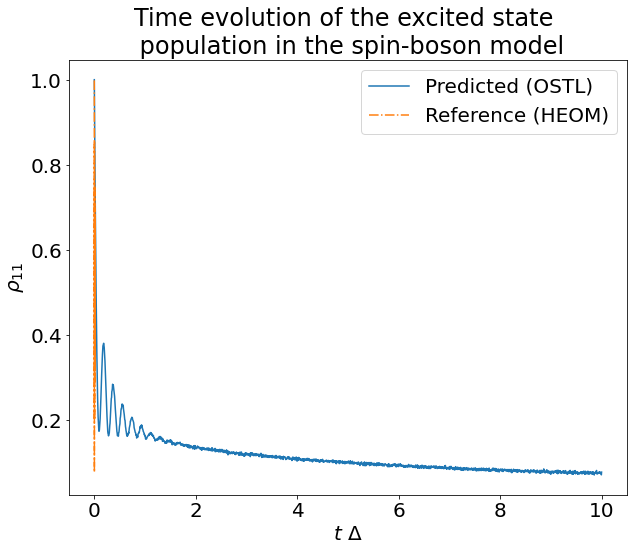

In [5]:
heom_dyn = np.load('test_set/sb/2_epsilon-0.0_Delta-1.0_lambda-0.1_gamma-4.0_beta-1.0.npy')
pred_dyn = np.load('Qd_trajectory.npy')
t_1 = np.real(heom_dyn[:,0])
t_2 = pred_dyn[:,0]
pred_state_1_pop = pred_dyn[:,1]
heom_state_1_pop = np.real(heom_dyn[:,1])

plt.rcParams['font.size'] = '20'
plt.figure(figsize=(10,8))
plt.plot(t_2, pred_state_1_pop, )
plt.plot(t_1, heom_state_1_pop, '-.')
plt.xlabel(r'$t \ \Delta$')
plt.ylabel(r'$\rho_{11}$')
plt.legend(["Predicted (OSTL)", 'Reference (HEOM)'])
plt.title('Time evolution of the excited state \n population in the spin-boson model')